# Escalamiento

Notebook para ejemplificar el funcionamiento de los diferentes escalamientos útiles para algoritmos de machine learning

## Escalamiento con Z-score

Tiene como objetivo centrar la distribución en 0 con una desviación estandar de 0. Útil para todos los ML algortihms que usan máximización de gradiente (diferencia de cuadrados), no recomendable para árboles de decisión.

$$ z = \frac{X - \mu}{\sigma} $$

In [1]:
import pandas as pd
from sklearn import preprocessing
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('6_wine_data.csv',header=None)
df = df[[0,1,2]]
df.columns = ['Class win', 'Alcohol', 'Malic acid']

In [3]:
scale = preprocessing.StandardScaler().fit(df[['Alcohol', 'Malic acid']])
df_z = scale.transform(df[['Alcohol', 'Malic acid']])

print('mean:',round(df_z.mean(),2), '  desviation:', round(df_z.std(),2))

mean: -0.0   desviation: 1.0


In [4]:
scale = preprocessing.MinMaxScaler().fit(df[['Alcohol', 'Malic acid']])
df_mm = scale.transform(df[['Alcohol', 'Malic acid']])

print('Min:',round(df_mm.min(),2), '  Max:', round(df_mm.max(),2))


Min: 0.0   Max: 1.0


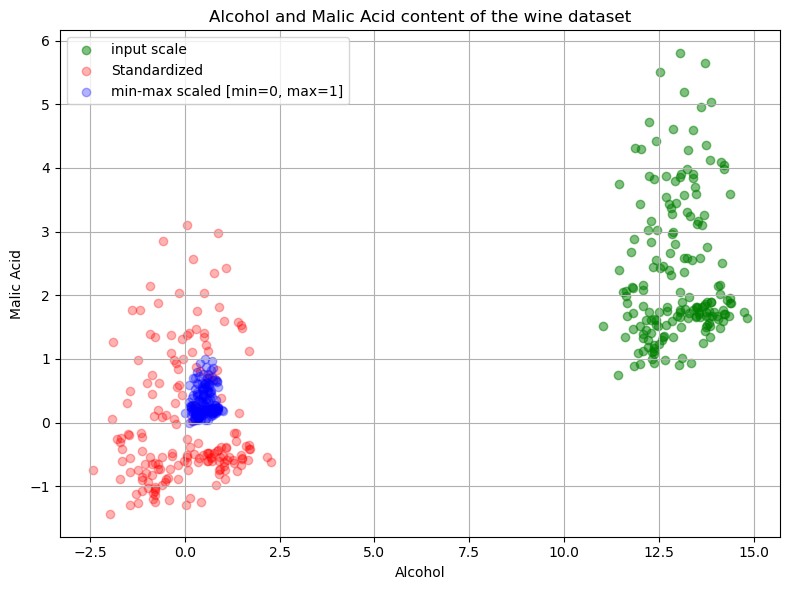

In [5]:
def plot():
    plt.figure(figsize=(8,6))

    plt.scatter(df['Alcohol'], df['Malic acid'],
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_z[:,0], df_z[:,1], color='red',
            label='Standardized', alpha=0.3)

    plt.scatter(df_mm[:,0], df_mm[:,1],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Alcohol and Malic Acid content of the wine dataset')
    plt.xlabel('Alcohol')
    plt.ylabel('Malic Acid')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()

plot()
plt.show()

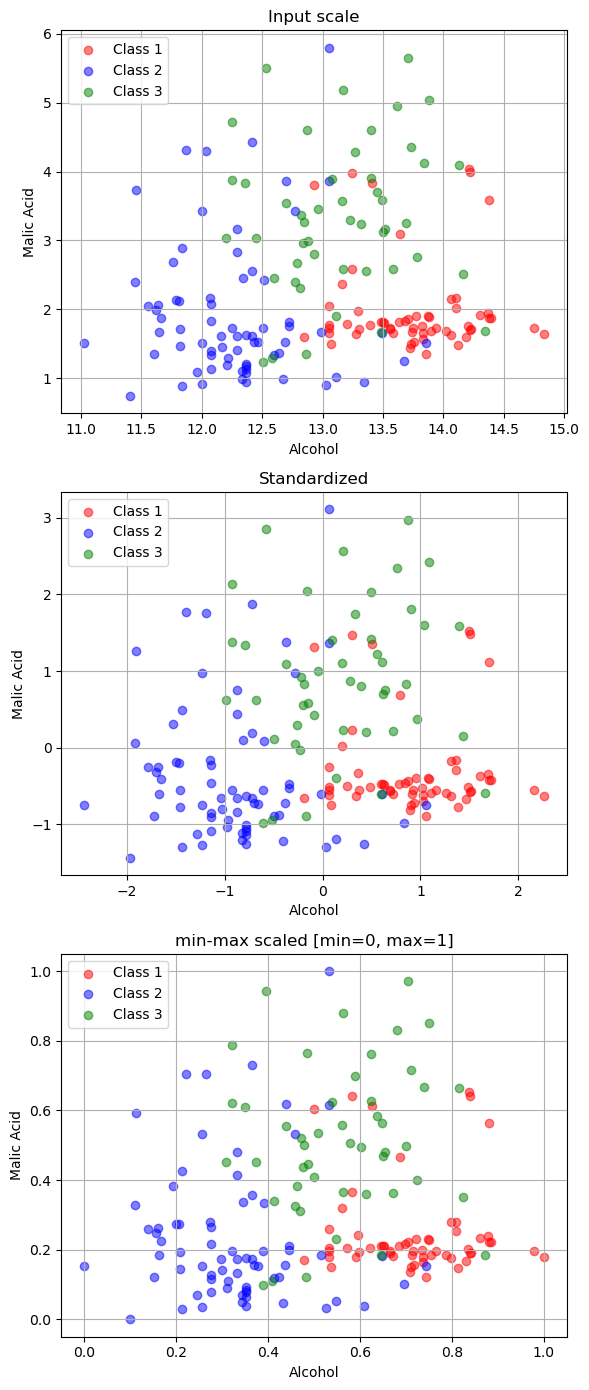

In [6]:
fig, ax = plt.subplots(3, figsize=(6,14))

for a,d,l in zip(range(len(ax)),
               (df[['Alcohol', 'Malic acid']].values, df_z, df_mm),
               ('Input scale',
                'Standardized',
                'min-max scaled [min=0, max=1]')
                ):
    for i,c in zip(range(1,4), ('red', 'blue', 'green')):
        ax[a].scatter(d[df['Class win'].values == i, 0],
                  d[df['Class win'].values == i, 1],
                  alpha=0.5,
                  color=c,
                  label='Class %s' %i
                  )
    ax[a].set_title(l)
    ax[a].set_xlabel('Alcohol')
    ax[a].set_ylabel('Malic Acid')
    ax[a].legend(loc='upper left')
    ax[a].grid()

plt.tight_layout()

plt.show()

Los anteriores scatters sirven para visualizar como cambia la distribución en el plano cartesiano. Sin embargo fuera de eso no se aprecian diferencias visibles. Para ello aprovechemos las el escalamiento con StandardScale() para poder potenciar un algorirtmo de PCA en le mismo data frame

In [7]:
from sklearn.model_selection import train_test_split

X_wine = df.values[:,1:] # Todas las filas de la segunda y tercer columna   INPUTS
y_wine = df.values[:,0] # Todas las filas de la primer columna   OUTPUT

# Separar los datos de forma aleatoria, entrenando con 70%
X_train, x_test, Y_train, y_test = train_test_split(X_wine, y_wine,
                                                   test_size=0.30,
                                                   random_state=12345)

In [8]:
# Se hace el escalamiento gaussiano sobre los inputs, tanto entrenamiento como testeo

scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = scale.transform(X_train)
x_test_std = scale.transform(x_test)

In [9]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2).fit(X_train) # Se reduce la dimensionalidad a 2 en los datos de entrenamiento

# Trasnforma los datos con la reducción
X_train = pca.transform(X_train)
x_test = pca.transform(x_test)

# Lo mismo para los datos escalados
pca = PCA(n_components=2).fit(X_train_std) 
X_train_std = pca.transform(X_train_std)
x_test_std = pca.transform(x_test_std)

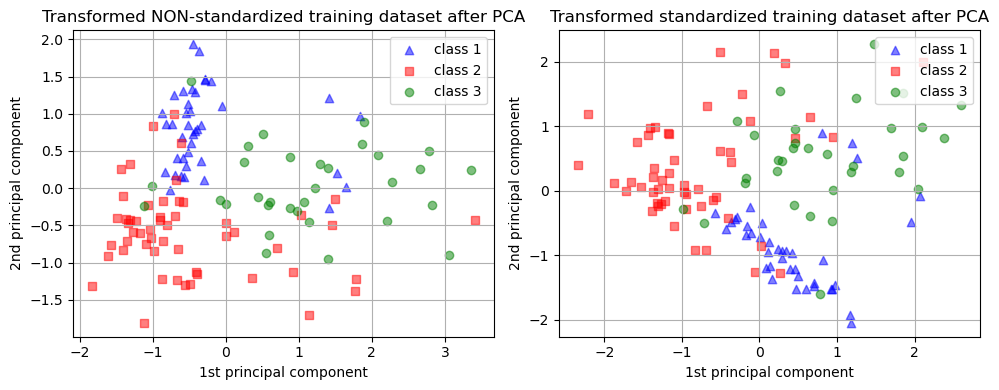

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))


for l,c,m in zip(range(1,4), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X_train[Y_train==l, 0], X_train[Y_train==l, 1],
        color=c,
        label='class %s' %l,
        alpha=0.5,
        marker=m
        )

for l,c,m in zip(range(1,4), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(X_train_std[Y_train==l, 0], X_train_std[Y_train==l, 1],
        color=c,
        label='class %s' %l,
        alpha=0.5,
        marker=m
        )

ax1.set_title('Transformed NON-standardized training dataset after PCA')    
ax2.set_title('Transformed standardized training dataset after PCA')    

for ax in (ax1, ax2):

    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()
plt.tight_layout()

plt.show()  

El modelo de Naive Bayes es un clasificador probabilístico basado en el teorema de Bayes con una suposición de independencia fuerte (naive) entre las inputs. Este modelo es simple pero poderoso, especialmente adecuado para tareas de clasificación de texto como el filtrado de spam, el análisis de sentimientos y la categorización de documentos.

La regla de decisión es $$ \omega_{1} \hspace{0.5cm} si \hspace{0.5cm} {P}(\omega_{1}|x) > {P}(\omega_{2}|x) \hspace{0.5cm} else \hspace{0.5cm} \omega_{2} $$

Es decir que si la probabilidad de que vino tipo 1 es más alta que la de que sea 2, entonces clasifica como 1. La probabildad se obtiene a partir de considerar ambos inputs.

In [11]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
fit = gnb.fit(X_train, Y_train)

gnb_std = GaussianNB()
fit_std = gnb_std.fit(X_train_std, Y_train)

In [12]:
from sklearn import metrics

pred_train = gnb.predict(X_train)

print('\nPrediction accuracy for the training dataset')
print('{:.2%}'.format(metrics.accuracy_score(Y_train, pred_train)))

pred_test = gnb.predict(x_test)

print('\nPrediction accuracy for the test dataset')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))


Prediction accuracy for the training dataset
79.84%

Prediction accuracy for the test dataset
77.78%



In [13]:
pred_train_std = gnb_std.predict(X_train_std)

print('\nPrediction accuracy for the training dataset')
print('{:.2%}'.format(metrics.accuracy_score(Y_train, pred_train_std)))

pred_test_std = gnb_std.predict(x_test_std)

print('\nPrediction accuracy for the test dataset')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))


Prediction accuracy for the training dataset
75.81%

Prediction accuracy for the test dataset
81.48%



# Escalamiento robusta 

La estandarización puede volverse sesgada si la variable de entrada contiene valores atípicos. Para ello se evita usar media y se reemplaza por la mediana y el rango intercuartilico. Con el mismo set de datos a continuación se demuestra como hacer el escalamiento robusto

array([[<Axes: title={'center': 'Class win'}>,
        <Axes: title={'center': 'Alcohol'}>],
       [<Axes: title={'center': 'Malic acid'}>, <Axes: >]], dtype=object)

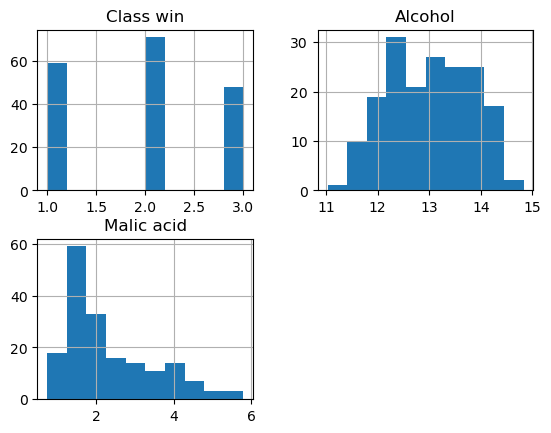

In [14]:
df.hist()

In [15]:
## Evaluación de modelo K means


from sklearn.model_selection import RepeatedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Suponiendo que tienes un DataFrame 'df' y un target 'target'
X = df.values  # O df.drop(columns=[target]).values si necesitas excluir el target

# Configuración de RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = []

# Realizar la validación cruzada
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    kmeans = KMeans(n_clusters=3, random_state=1)
    kmeans.fit(X_train)
    labels = kmeans.predict(X_test)
    score = silhouette_score(X_test, labels)
    scores.append(score)

print("Silhouette scores:", scores)
print('')
print("Average silhouette score:", np.mean(scores))


Silhouette scores: [0.5338974224085766, 0.5328418123553793, 0.5886531986393746, 0.3387764710257116, 0.40785524102280496, 0.3582991034419259, 0.4450405444542595, 0.5664530951463658, 0.5271298920278708, 0.39763954117261596, 0.5025192405153371, 0.4620522623028209, 0.5274076214897735, 0.512879206230887, 0.38931053163100887, 0.555374769727851, 0.350144717073203, 0.513067373380407, 0.6565587432974038, 0.3314189114411961, 0.5795175388269701, 0.46995595223563097, 0.43794466611435723, 0.4525859622850066, 0.4966151930297278, 0.5867184183968344, 0.640578212741403, 0.6374619362961399, 0.38365733603033264, 0.39633459069061977]

Average silhouette score: 0.4859563168477265


In [20]:
def get_model_result(dff):
    # Suponiendo que tienes un DataFrame 'df' y un target 'target'
    X = dff.values  # O df.drop(columns=[target]).values si necesitas excluir el target

    # Configuración de RepeatedKFold
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    scores = []

    # Realizar la validación cruzada
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        kmeans = KMeans(n_clusters=3, random_state=1)
        kmeans.fit(X_train)
        labels = kmeans.predict(X_test)
        score = silhouette_score(X_test, labels)
        scores.append(score)

    #print("Silhouette scores:", scores)
    print('')
    print("Average silhouette score:", np.mean(scores))

In [17]:
# Importar transformador de escalador Robusto
from sklearn import preprocessing

escaled_df = df.copy()
trans = preprocessing.RobustScaler().fit(escaled_df[['Alcohol', 'Malic acid']])
escaled_df[['Alcohol', 'Malic acid']] = trans.transform(df[['Alcohol', 'Malic acid']])

In [18]:
get_model_result(escaled_df)

Silhouette scores: [0.5654351903136597, 0.5490224953648837, 0.6295784140206941, 0.3833560698960949, 0.4183181628802559, 0.3690675693145455, 0.5374701772322106, 0.5924881964447416, 0.5841798334388295, 0.3360606206225012, 0.5603195938065954, 0.5032462022332269, 0.48021218184169734, 0.5028035719804346, 0.3900474112093735, 0.6171070032869154, 0.375619228915911, 0.548294699619971, 0.5930974532188066, 0.49602418395478076, 0.5811293369115828, 0.4277463646281312, 0.4452667849759942, 0.4917395060554512, 0.4984830906923628, 0.6318133594485648, 0.6817953999241824, 0.6497405391499959, 0.4269029182203934, 0.46048222667637373]

Average silhouette score: 0.5108949262093053


Por default el robust Scalere utiliza el quantile 0.25 y 0.75 pero es configurable

trans = RobustScaler(quantile_range=(quantile_1, quantile_3))

In [28]:
for value in [1, 5, 10, 15, 20, 25, 30]:
    escaled_df = df.copy()
    trans = preprocessing.RobustScaler(quantile_range=(value, 100-value)).fit(escaled_df[['Alcohol', 'Malic acid']])
    escaled_df[['Alcohol', 'Malic acid']] = trans.transform(df[['Alcohol', 'Malic acid']]) 
    
    get_model_result(escaled_df)
    print(f'Quantile: {value}')
    print('')
                  


Average silhouette score: 0.7238551570550541
Quantile: 1


Average silhouette score: 0.6671441188123989
Quantile: 5


Average silhouette score: 0.6224626604222759
Quantile: 10


Average silhouette score: 0.5876899958122617
Quantile: 15


Average silhouette score: 0.5398204824452473
Quantile: 20


Average silhouette score: 0.5108949262093053
Quantile: 25


Average silhouette score: 0.4877465139694469
Quantile: 30



# Discretization and Binning

Se trata de una técnica de agrupamiento en los datos para darles un mejor tratamiento o alcanzar objetivos especificos como distribuciones normales

In [30]:
# Considere el siguiente vector de edades
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

In [31]:
# Se puede crear un segundo vector para cortar las edades de forma [)
bins = [18,25,30,42,60]

new = pd.cut(ages, bins)

In [32]:
# Cada sublist representa un elemento y el rango en que el esta
new

[(18, 25], (18, 25], (18, 25], (25, 30], (18, 25], ..., (30.0, 42.0], NaN, (42.0, 60.0], (30.0, 42.0], (30.0, 42.0]]
Length: 12
Categories (4, interval[int64, right]): [(18, 25] < (25, 30] < (30, 42] < (42, 60]]

In [33]:
# Si quisieramos ver la cantidad de datos que se encuntran en dicho rango
new.codes

array([ 0,  0,  0,  1,  0,  0,  2,  2, -1,  3,  2,  2], dtype=int8)

In [36]:
# ver intervalo unicos
new.categories

IntervalIndex([(18, 25], (25, 30], (30, 42], (42, 60]], dtype='interval[int64, right]')

In [34]:
# Ver rango y frecuencia

pd.value_counts(new)

(18, 25]    5
(30, 42]    4
(25, 30]    1
(42, 60]    1
Name: count, dtype: int64

In [39]:
# Tambíen puedes escoger el categorizador que se agregara a cada caso 
# Cuidando dar n - 1 labels
new = pd.cut(ages, bins, labels=['Group_1', 'Group_2', 'Group_3', 'Group_4'])

In [40]:
pd.value_counts(new)

Group_1    5
Group_3    4
Group_2    1
Group_4    1
Name: count, dtype: int64

In [44]:
# Distribución uniforme de 20 valores entre 0 y 1
data = np.random.uniform(size=20)

pd.cut(data, bins=4, precision=2) #Corta los datos para tener mismo numero de bins.
# Divide el set de min a max y corta en n, compara con precisión de 2 decimales

[(0.5, 0.75], (0.5, 0.75], (0.5, 0.75], (0.5, 0.75], (0.5, 0.75], ..., (0.75, 0.99], (0.5, 0.75], (0.0044, 0.25], (0.25, 0.5], (0.0044, 0.25]]
Length: 20
Categories (4, interval[float64, right]): [(0.0044, 0.25] < (0.25, 0.5] < (0.5, 0.75] < (0.75, 0.99]]

In [45]:
#Dividir los datos en quantiles
np.random.standard_normal(1000)

quartiles = pd.qcut(data, 4, precision=2)

quartiles

[(0.6, 0.64], (0.6, 0.64], (0.27, 0.6], (0.64, 0.99], (0.6, 0.64], ..., (0.64, 0.99], (0.6, 0.64], (-0.0046, 0.27], (0.27, 0.6], (-0.0046, 0.27]]
Length: 20
Categories (4, interval[float64, right]): [(-0.0046, 0.27] < (0.27, 0.6] < (0.6, 0.64] < (0.64, 0.99]]

In [47]:
quartiles.value_counts()

(-0.0046, 0.27]    5
(0.27, 0.6]        5
(0.6, 0.64]        5
(0.64, 0.99]       5
Name: count, dtype: int64

In [46]:
# Cortar a partir de valores y no de porcentajes
pd.qcut(data, [0, 0.1, 0.5, 0.9, 1.]).value_counts()

(0.00442, 0.032]    2
(0.032, 0.602]      8
(0.602, 0.726]      8
(0.726, 0.993]      2
Name: count, dtype: int64

# Codificaciones ordinales y one-hot

In [54]:
from sklearn import preprocessing

In [61]:
## Clasificación ordinal

#Alternativamente existe LabelEncoder

color = np.asarray([['red'], ['green'], ['blue']])

encoder = preprocessing.OrdinalEncoder()


In [62]:
encoder.fit_transform(color)

array([[2.],
       [1.],
       [0.]])

In [63]:
# Note la diferencia 


color = np.asarray([['rojo'], ['verde'], ['azul']])
encoder = preprocessing.OrdinalEncoder()
encoder.fit_transform(color)

array([[1.],
       [2.],
       [0.]])

In [69]:
# Uso para vatoables catogoricas no ordinales
code = preprocessing.OneHotEncoder(sparse=False)
code.fit_transform(color)

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [70]:
# Uso para vatoables catogoricas no ordinales con variable Ficticia
code = preprocessing.OneHotEncoder(drop='first', sparse=False)
code.fit_transform(color)

# Se nota que se hace una mascara de dimension n-1, llena de ceros para las observaciones 'blue' pues es la linea base

array([[1., 0.],
       [0., 1.],
       [0., 0.]])

La codificación de valores Nan es algo que se hace en variables categoricas, Si hay datos numericos y categoricos, lo correcto es separar los numericos, codificar los categoricos y volver a concatenar

# Tranformaciones estabilizadoras de varianza

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.datasets import fetch_california_housing

In [72]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

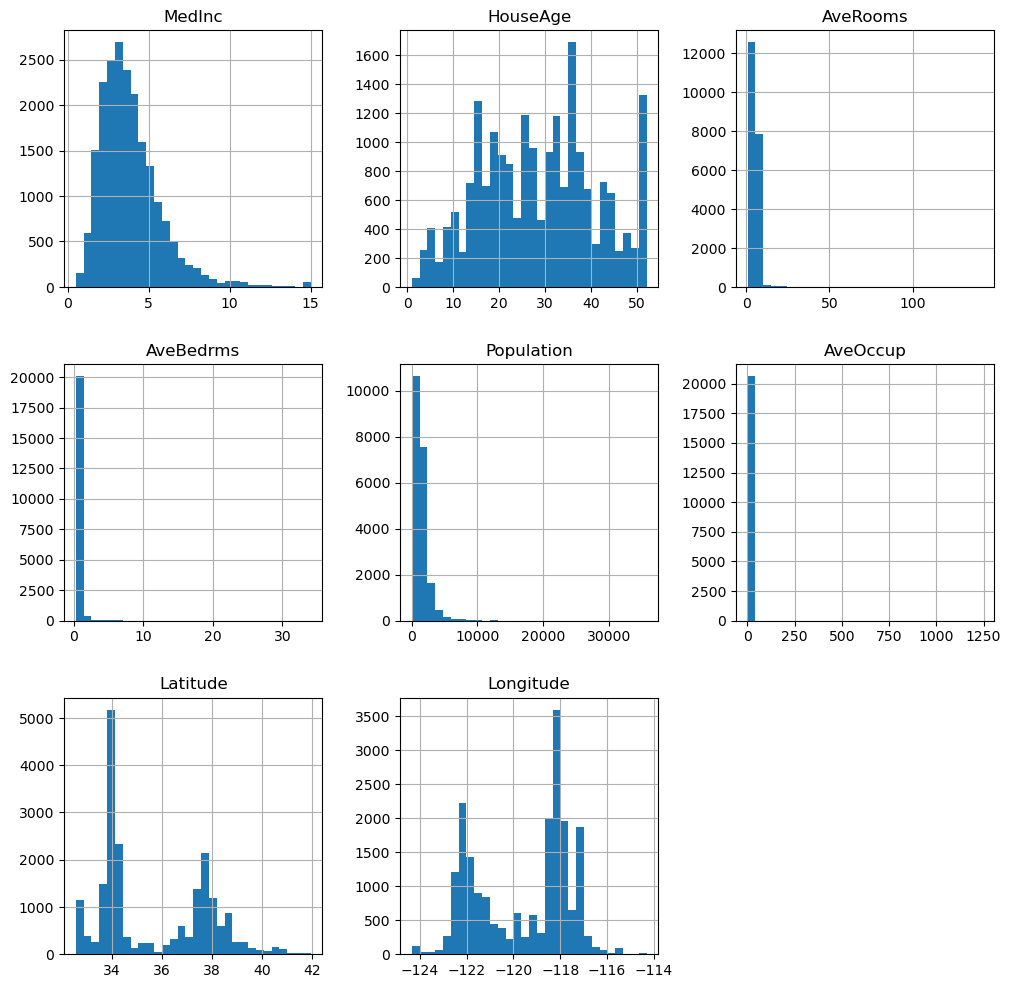

In [73]:
X.hist(bins=30, figsize=(12, 12))

plt.show()

In [74]:
## Función para crear gráficos Q-Q

def diagnostic_plots(df, variable):

    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.title(f"Histogram of {variable}")
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"Q-Q plot of {variable}")

    plt.show()

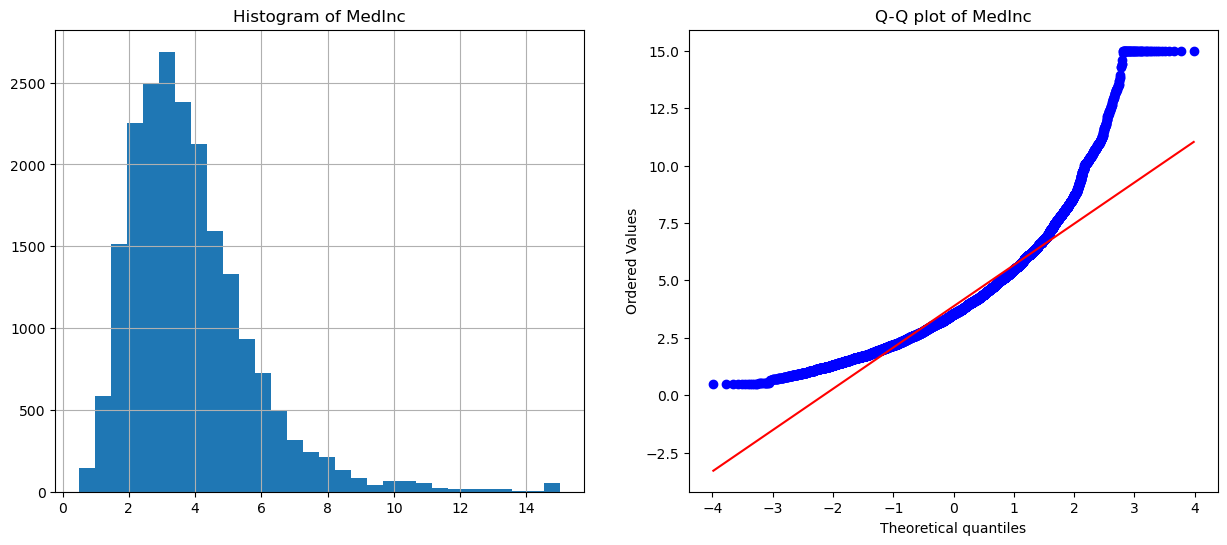

In [75]:
diagnostic_plots(X, "MedInc")

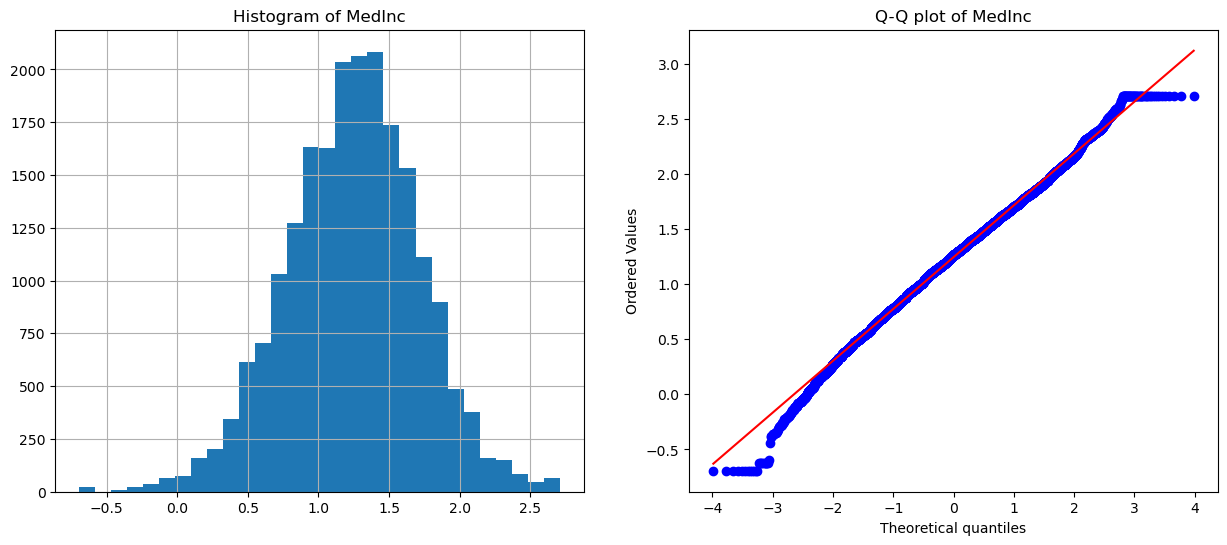

In [77]:
X_tf = X.copy()
variables = ["MedInc", "AveRooms", "AveBedrms", "Population"] # Variables para aplicar logaritmo

# Si hay cero o negativos. Poner un offset
X_tf[variables] = np.log(X[variables])

diagnostic_plots(X_tf, "MedInc")

In [79]:
# De utilidad por si los dados se quieren regresar antes de hacer la transfromación

from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log, inverse_func=np.exp)
X_tf[variables] = transformer.transform(X[variables])



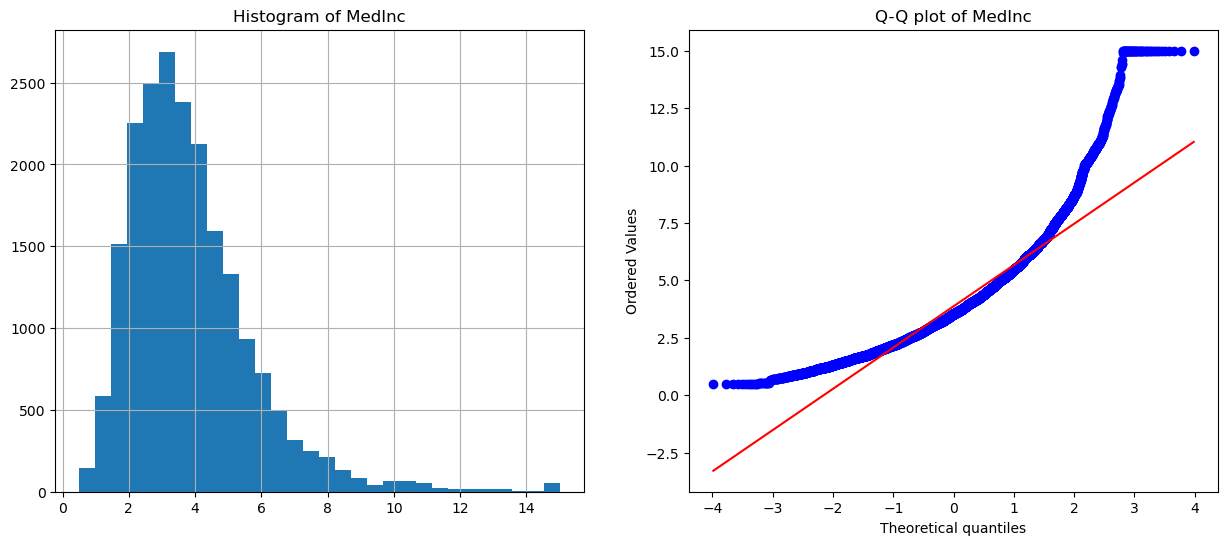

In [81]:
X_tf[variables] = transformer.inverse_transform(X_tf[variables])
diagnostic_plots(X_tf, "MedInc")

In [85]:
from feature_engine.transformation import LogTransformer

# También existe LogCpTransformer para valores no positivos.
lt = LogTransformer(variables = variables)

lt.fit(X)

LogTransformer(variables=['MedInc', 'AveRooms', 'AveBedrms', 'Population'])

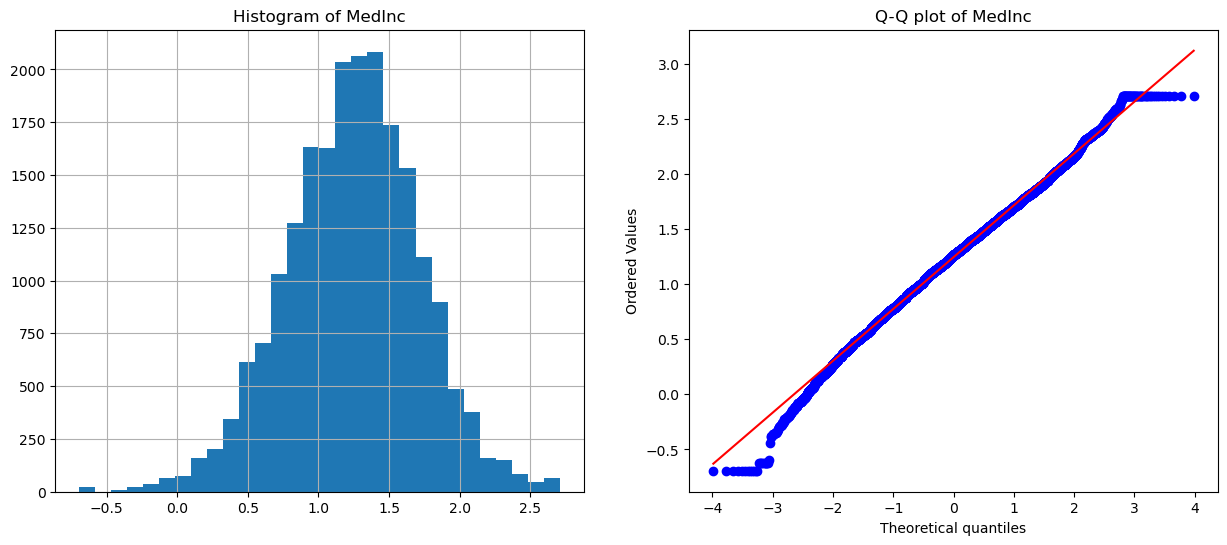

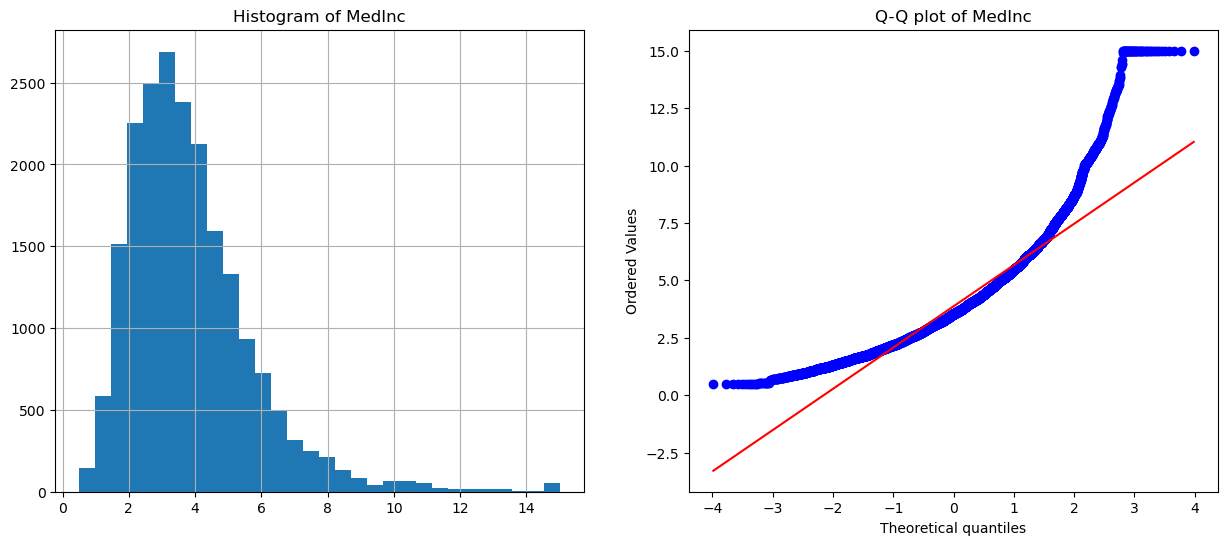

In [88]:
X_tf = lt.transform(X)
diagnostic_plots(X_tf, "MedInc")
X_tf = lt.inverse_transform(X_tf)
diagnostic_plots(X_tf, "MedInc")


# Transformación reciproca

Se trata de 1/x por lo que no está definida para x=0 pero si en negativos, es de utilidad para variables **ratio** es decir, cociente de dos valores como el número de ocupantes por casa

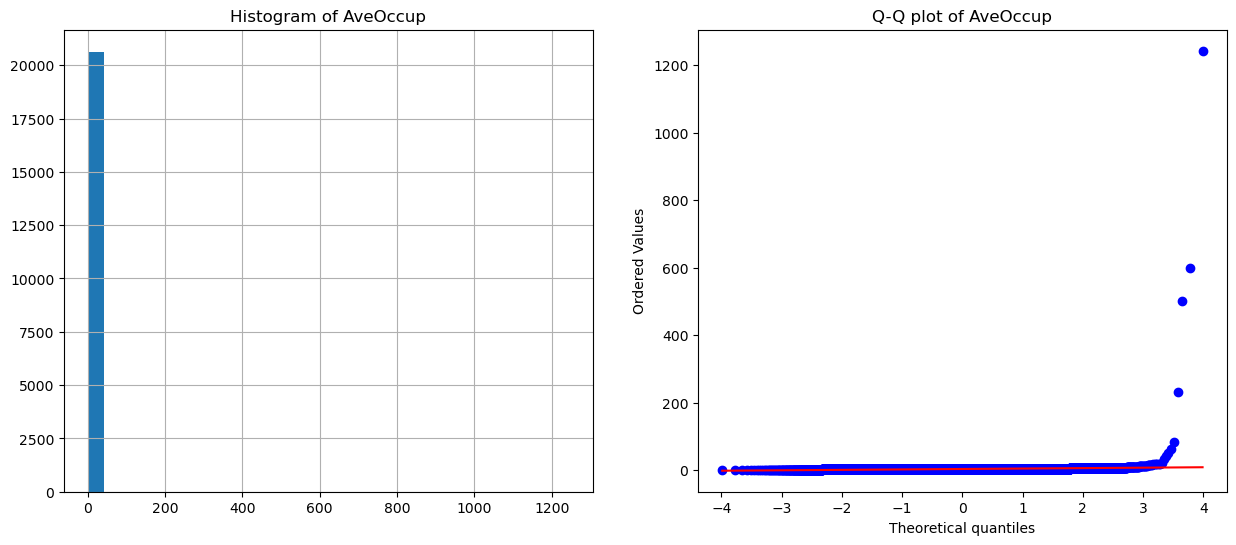

In [89]:
diagnostic_plots(X, "AveOccup")


In [91]:
AveOccup = X.copy()
AveOccup['AveOccup'] = np.reciprocal(AveOccup['AveOccup'])

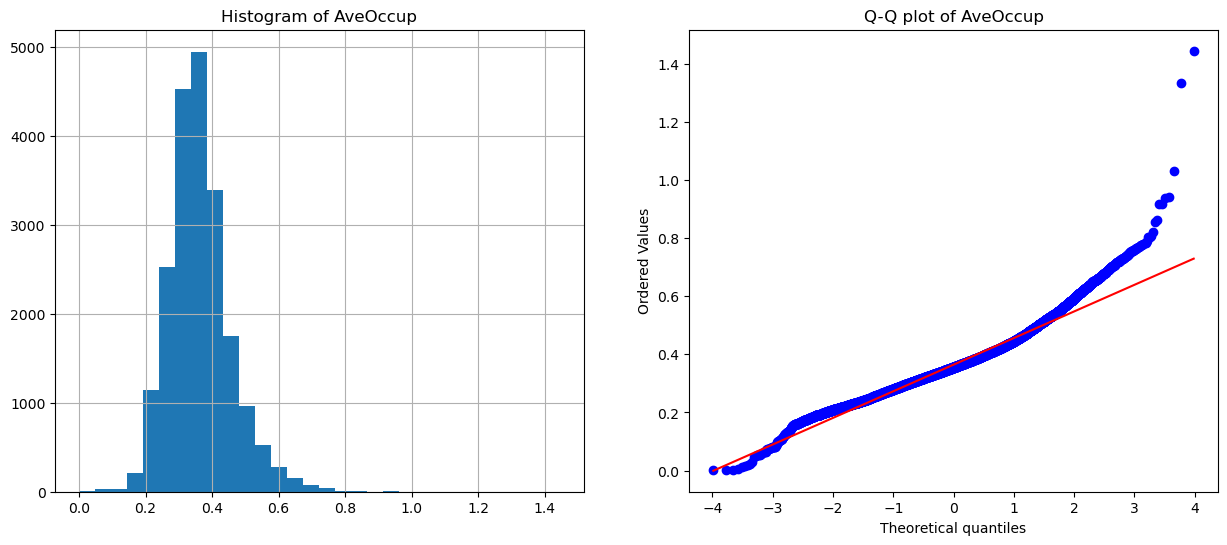

In [93]:
diagnostic_plots(AveOccup, "AveOccup")

In [97]:
# Ejemplo utilizando feature_engineering

from feature_engine.transformation import ReciprocalTransformer

# Definimos que en que variable trabajara
rt = ReciprocalTransformer(variables="AveOccup")

rt.fit(X)

ReciprocalTransformer(variables='AveOccup')

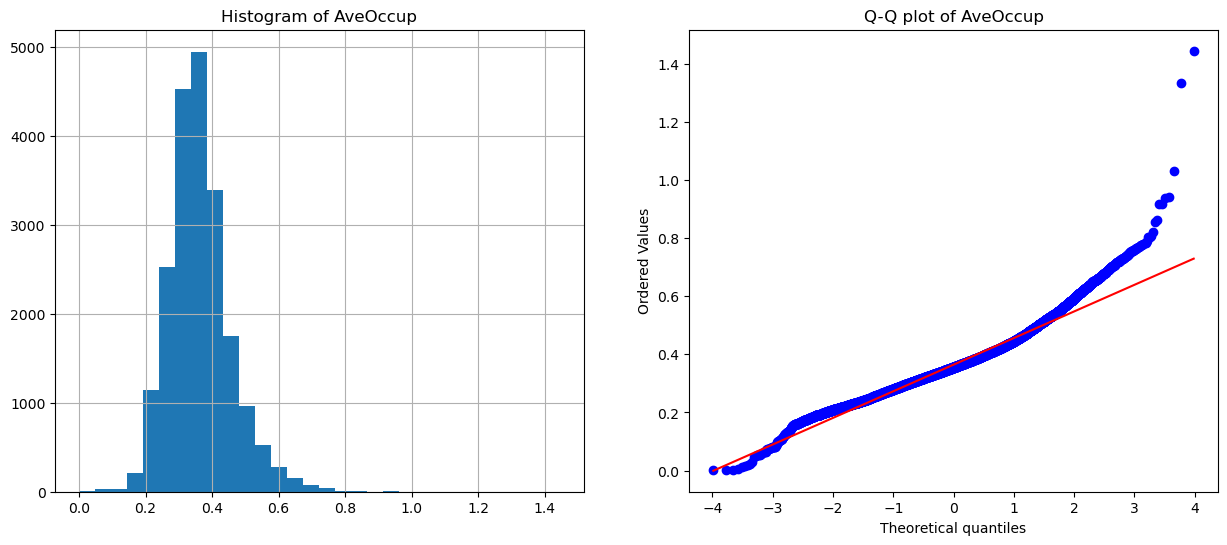

In [98]:
X_tf = rt.transform(X)
diagnostic_plots(X_tf, "AveOccup")

# Raíz cuadrada

Junto con transformada de Anscombe, √(x+3/8), y la transformación de Freeman-Tukey, √x + √(x+1) se encargan de transformar distribución de Poisson a Normal. Solo útil para valores positivos y generalmente son variables que definen la probabilidad de ocurrencia de algun evento como decaimiento nuclear, cantidad de personas en un hogar o en vehiculo

from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.sqrt)


from feature_engine.transformation import PowerTransformer

root_t = PowerTransformer(exp=1/2, variables=variables)
root_t.fit(df)


# Potencia

Caso general de raíz cuadrada y a su vez Box-Cox es una generalización de las potencias pues encuntra la potencia lambda de acuerdo al maximo de verosimilitud. Cuando esta sesgada a la derecha se usa lambda menor a 1, de lo contrario mayor a 1.


# Box-Cox
* Retorna reciproca si lambda = -1

* Retorna el logaritmo si lambda = 0

* Retorn raiz cuadrada si lambda = 0.5

* Invarianza si lamda = 0


bct = BoxCoxTransformer()

bct.fit(X)

X_tf = bct.transform(X)

Y para ver los lambda optimos:

bct.lambda_dict_


# Yeo Johnson
actua al igual que box-cox sin limitarse a valores positivos, para los negativo actua igual que box_cox para positivos pero + 1 y potenciado para dos. Es función partida (cambia su actuar) dependiendo el valor de x (si es negativa o positiva)

from feature_engine.transformation import YeoJohnsonTransformer

yjt = YeoJohnsonTransformer()

yjt.fit(X)

yjt.lambda_dict_

